In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

# pd.options.display.max_columns = 50
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

plt.rcParams.update({'figure.figsize':(15,3), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

In [2]:
import sys  
sys.path.append('../src') 
from edge import *
from edge_risk_kit import *
import edge_risk_kit as erk

In [3]:
import requests
import io
import string
import re
from pprint import pprint
from tqdm.notebook import tqdm
import io

In [4]:
DATA_FOLDER = 'C:/Users/20075503d/Desktop/data/'
createfolder(DATA_FOLDER)

In [5]:
snp = pd.read_csv(DATA_FOLDER + '/high-esg.const.csv')

In [6]:
snp.set_index('Symbol', inplace=True)

In [7]:
snp.head()

,Name,Sector
Symbol,,
NVDA,Nvidia,Information Technology
MSFT,Microsoft,Information Technology
BBY,Best Buy,Consumer Discretionary
ADBE,Adobe,Information Technology
POOL,Pool Corporation,Consumer Discretionary


In [8]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


In [9]:
import yfinance as yf

In [10]:
tickers = snp.index.to_list()

In [11]:
tickers

['NVDA', 'MSFT', 'BBY', 'ADBE', 'POOL', 'CRM', 'CDNS', 'INTU', 'IDXX', 'LRCX']

In [12]:
start_date = '2012-01-01'
end_date = '2023-03-27'

In [13]:
data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  10 of 10 completed


In [14]:
prices = data['Adj Close'][tickers]

In [15]:
import pandas as pd
import numpy as np
prices.to_csv(DATA_FOLDER + 'prices.csv')
prices = prices.fillna(0)

In [16]:
prices = pd.read_csv(DATA_FOLDER + '/prices.csv')

In [17]:
prices.Date = pd.to_datetime(prices.Date)
prices.set_index('Date', inplace=True)
prices.index = pd.to_datetime(prices.index, utc=True)
type(prices.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [18]:
prices = prices[prices.columns[prices.count() == prices.count().max()]]

In [20]:
import plotly.express as px
prices_returns = prices.pct_change()
prices_rets_cumprod = prices_returns.add(1).cumprod().sub(1)*100

fig = px.line(prices_rets_cumprod, x=prices_rets_cumprod.index, y=prices_rets_cumprod.columns, title='Cumulative Returns of High-ESG Stocks (2010-2020)')

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cumulative Return in %')

fig.show()

In [21]:
!pip install PyPortfolioOpt

from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import exp_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.plotting import plot_weights
from pypfopt.cla import CLA

Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
anaconda-project 0.10.2 requires ruamel-yaml, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.22.4 which is incompatible.


In [22]:
prices_returns.astype(float)
train = prices_returns.loc[:"2017-01-03"]
test = prices_returns.loc["2017-01-03":]

In [23]:
mu = expected_returns.ema_historical_return(train, returns_data = True, span = 500)
Sigma = risk_models.exp_cov(train, returns_data = True, span = 180)

In [24]:
ret_ef = np.arange(0, 0.879823, 0.01)

In [25]:
ret_ef

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87])

In [26]:
vol_ef = []
for i in np.arange(0, 0.879823, 0.01):
    ef = EfficientFrontier(mu, Sigma)
    ef.efficient_return(i)
    vol_ef.append(ef.portfolio_performance()[1])


In [27]:
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
ef.min_volatility()
min_vol_ret = ef.portfolio_performance()[0]
min_vol_vol = ef.portfolio_performance()[1]

ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
ef.max_sharpe(risk_free_rate=0.009)
max_sharpe_ret = ef.portfolio_performance()[0]
max_sharpe_vol = ef.portfolio_performance()[1]

In [28]:
max_sharpe_ret

0.9963664609979519

In [29]:
max_sharpe_vol

0.2653781889262291

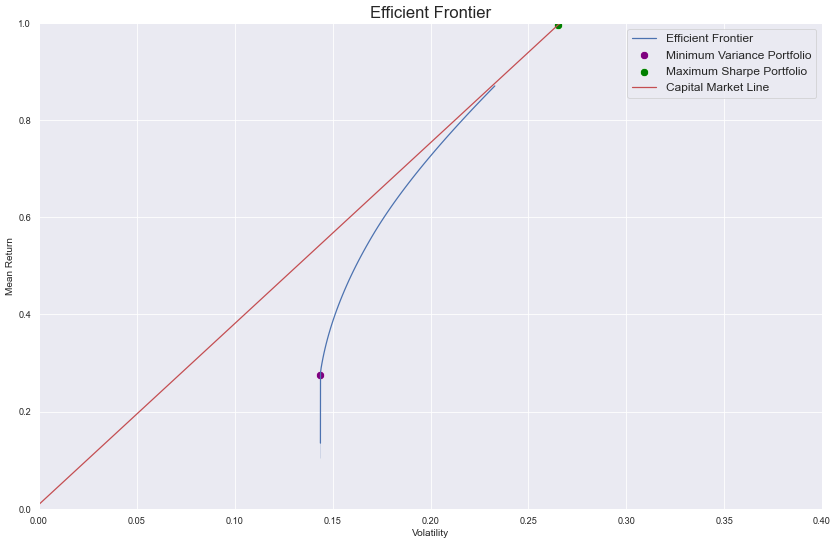

In [30]:
sns.set()

fig, ax = plt.subplots(figsize = [15,10])

sns.lineplot(x = vol_ef, y = ret_ef, label = "Efficient Frontier", ax = ax)
sns.scatterplot(x = [min_vol_vol], y = [min_vol_ret], ax = ax, label = "Minimum Variance Portfolio", color = "purple", s = 100)
sns.scatterplot(x = [max_sharpe_vol], y = [max_sharpe_ret], ax = ax, label = "Maximum Sharpe Portfolio", color = "green", s = 100)
sns.lineplot(x = [0, max_sharpe_vol, 1], y = [0.009, max_sharpe_ret, 3.096], label = "Capital Market Line", ax = ax, color = "r")

ax.set(xlim = [0, 0.4])
ax.set(ylim = [0, 1])
ax.set_xlabel("Volatility")
ax.set_ylabel("Mean Return")
plt.legend(fontsize='large')
plt.title("Efficient Frontier", fontsize = '20')

ax.figure.savefig("EffFront_big.png", dpi = 300)

Expected annual return: 27.5%
Annual volatility: 14.4%
Sharpe Ratio: 1.85


(0.27481249808088565, 0.1437662377036783, 1.848921571062889)

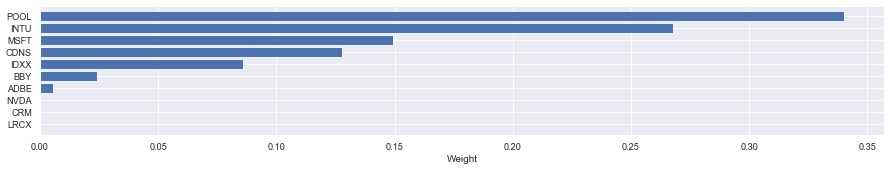

In [31]:
ef = EfficientFrontier(mu, Sigma)
raw_weights_minvar_exp = ef.min_volatility()

plot_weights(raw_weights_minvar_exp)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)
# this is the minimum variance portfolio

Expected annual return: 99.6%
Annual volatility: 26.5%
Sharpe Ratio: 3.72


(0.9963664609979519, 0.2653781889262291, 3.720601399056288)

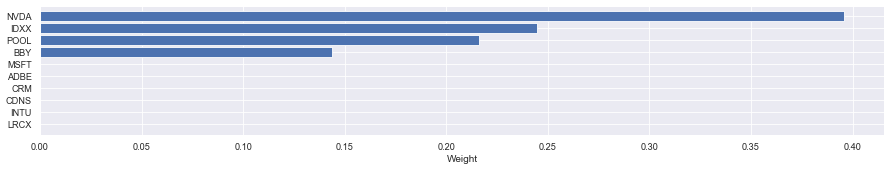

In [32]:
ef = EfficientFrontier(mu, Sigma)
raw_weights_maxsharpe_exp = ef.max_sharpe(risk_free_rate=0.009)

plot_weights(raw_weights_maxsharpe_exp)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)
# this is the maximum sharpe ratio portfolio